In [108]:
from model_drift import settings, helpers
import pandas as pd
import numpy as np
import json
import glob
import tqdm
import seaborn as sns
import matplotlib.pylab as plt

import warnings
warnings.filterwarnings("ignore")


In [252]:
input_df = pd.read_csv(str(settings.TOP_DIR.joinpath("results", 'drift_csvs', 'input_data_drift_D-30D.csv')), index_col=0, header=[0,1,2])
perf_df = pd.read_csv(str(settings.TOP_DIR.joinpath("results", 'drift_csvs', 'perf-micro_D-30D.csv')), index_col=0, header=[0, 1, 2])
score_df = pd.read_csv(str(settings.TOP_DIR.joinpath("results", 'drift_csvs',
                       'score_data_drift_D-30D.csv')), index_col=0, header=[0, 1, 2])

vae_df = pd.read_csv(str(settings.TOP_DIR.joinpath("results", 'drift_csvs',
                                                   'vae-mu_drift_D-30D.csv')), index_col=0, header=[0, 1, 2])


In [253]:
vae_df.head()

count          mu.0                           \
           Unnamed: 1_level_1            ks                            
           Unnamed: 1_level_2 critical_diff critical_value  distance   
2007-05-03                2.0     -0.346485       0.865448  0.518962   
2007-05-04                2.0     -0.346485       0.865448  0.518962   
2007-05-05                2.0     -0.346485       0.865448  0.518962   
2007-05-06                2.0     -0.346485       0.865448  0.518962   
2007-05-07                2.0     -0.346485       0.865448  0.518962   

                              mu.1                                     \
                                ks                                      
                pval critical_diff critical_value  distance      pval   
2007-05-03  0.462794     -0.377041       0.865448  0.488406  0.545299   
2007-05-04  0.462794     -0.377041       0.865448  0.488406  0.545299   
2007-05-05  0.462794     -0.377041       0.865448  0.488406  0.545299   
2007-05-06  0.462794     -0.377041       0.865448  0.488406  0.545299   
2007-05-07  0.462794     -0.377041       0.865448  0.488406  0.545299   

                   mu.10  ...     mu.97                   mu.98  \
                      ks  ...        ks                      ks   
           critical_diff  ...  distance      pval critical_diff   
2007-05-03     -0.465729  ...  0.454575  0.665192     -0.371736   
2007-05-04     -0.465729  ...  0.454575  0.665192     -0.371736   
2007-05-05     -0.465729  ...  0.454575  0.665192     -0.371736   
2007-05-06     -0.465729  ...  0.454575  0.665192     -0.371736   
2007-05-07     -0.465729  ...  0.454575  0.665192     -0.371736   

                                                      mu.99                 \
                                                         ks                  
           critical_value  distance      pval critical_diff critical_value   
2007-05-03       0.865448  0.493712  0.524836     -0.010925       0.865448   
2007-05-04       0.865448  0.493712  0.524836     -0.010925       0.865448   
2007-05-05       0.865448  0.493712  0.524836     -0.010925       0.865448   
2007-05-06       0.865448  0.493712  0.524836     -0.010925       0.865448   
2007-05-07       0.865448  0.493712  0.524836     -0.010925       0.865448   

                                
                                
            distance      pval  
2007-05-03  0.854523  0.042327  
2007-05-04  0.854523  0.042327  
2007-05-05  0.854523  0.042327  
2007-05-06  0.854523  0.042327  
2007-05-07  0.854523  0.042327  

[5 rows x 513 columns]

In [251]:


vae_cols = [c for c in list(vae_df) if 'mu' in c[0]]
vae_df_temp = vae_df[vae_cols].swaplevel(0, 2, axis=1).sort_index(axis=1)

vae_df_mean = pd.concat({"mu": pd.concat({c: vae_df_temp[c].mean(axis=1) for c in {
    (c[0], c[1]) for c in list(vae_df_temp)}}, axis=1)}, axis=1).swaplevel(1, 2, axis=1)

vae_df_mean
# vae_df2.columns = [('mu', c[0], c[1]) for c in list(vae_df2)]


mu                                  
                       ks                                  
           critical_value  distance critical_diff      pval
2007-05-03       0.865448  0.532256     -0.333192  0.507699
2007-05-04       0.865448  0.532256     -0.333192  0.507699
2007-05-05       0.865448  0.532256     -0.333192  0.507699
2007-05-06       0.865448  0.532256     -0.333192  0.507699
2007-05-07       0.865448  0.532256     -0.333192  0.507699
...                   ...       ...           ...       ...
2017-11-13       0.039471  0.087643      0.048172  0.068174
2017-11-14       0.038908  0.087407      0.048500  0.061855
2017-11-15       0.038190  0.086928      0.048737  0.057012
2017-11-16       0.038419  0.086052      0.047633  0.057334
2017-11-17       0.038737  0.085593      0.046856  0.056608

[3791 rows x 4 columns]

In [333]:
import six
from functools import reduce
from sklearn.feature_selection import mutual_info_classif

def merge_frames(*dfs, **join_kwargs):
    join_kwargs.setdefault('how', "inner")
    return reduce(lambda df1, df2: df1.join(df2, **join_kwargs), dfs)

def column_xs(df, include=None, exclude=None):

    if isinstance(include, six.string_types):
        include = [include]

    if isinstance(exclude, six.string_types):
        exclude = [exclude]
    
    cols = df.columns.tolist()
    if include is not None:
        cols = [col for col in cols if any(i in col for i in include)]

    exclude = exclude or []
    cols = [col for col in cols if not any(e in col for e in exclude)]
    
    return cols


def flatten_index(df, sep='.'):
    def __flatten_index(c):
        if isinstance(c, six.string_types):
            return c
        return sep.join(c)
    _df = df.copy()
    _df.columns = [__flatten_index(col) for col in _df.columns]
    return _df


def align_frames(perf_dataframe, other_dataframe, how='inner', include=None, exclude=None):
    corr_cols = column_xs(other_dataframe, include=include, exclude=exclude)
    target_col = list(perf_dataframe.columns)[0]
    mdf = other_dataframe[corr_cols].join(perf_dataframe[target_col], how=how)
    return mdf[corr_cols], mdf[target_col]


def correlate_performance(perf_dataframe, other_dataframe, **kwargs):
    X, Y = align_frames(perf_dataframe, other_dataframe, **kwargs)
    return X.corrwith(Y).rename("correlation")
    

def mutual_info_performance(perf_dataframe, other_dataframe, bins=10, **kwargs):
    X, Y = align_frames(perf_dataframe, other_dataframe, **kwargs)
    Y, bins = pd.cut(Y, bins=bins, retbins=True)
    info_gain = mutual_info_classif(X.values, Y.cat.codes)
    return pd.Series(info_gain, index=X.columns.tolist(), name="info_gain")


def df_standard_scale(idf, nstd=1):
    stats = idf.agg(["mean", "std"])
    return (idf-stats.loc['mean'])/(stats.loc["std"])




,info_gain,abs_correlation
info_gain,1.000000,0.527459
abs_correlation,0.527459,1.000000


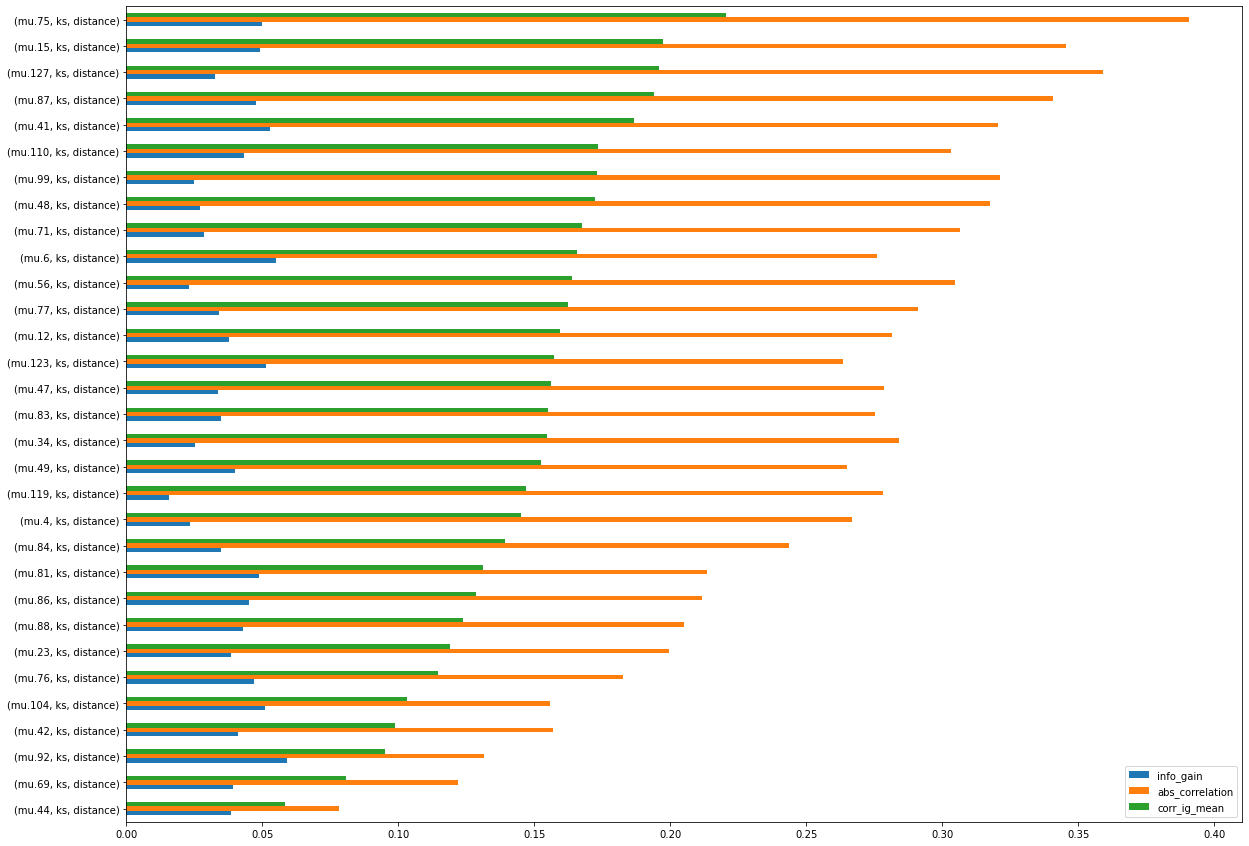

In [360]:
mu_corr_df = correlate_performance(perf_df['score']['label'], vae_df, include='distance')
mu_ig_df = mutual_info_performance(perf_df['score']['label'], vae_df, bins=3, include='distance')

# mu_corr_df = df_standard_scale(mu_corr_df)
# mu_ig_df = df_standard_scale(mu_ig_df)



N = 20
mu_corr_df_top = mu_corr_df.iloc[mu_corr_df.abs().argsort()[::-1]].iloc[:N]

mu_ig_df_top = mu_ig_df.sort_values(ascending=False).iloc[:N]

mu_ig_df_top


m = mu_ig_df.to_frame().join(mu_corr_df.abs().rename('abs_correlation'))
m = m.join(m.mean(axis=1).rename('corr_ig_mean'))

mean_top = m.sort_values(by='abs_correlation', ascending=False).iloc[:N]
m_top = m.loc[set(mu_corr_df_top.index.to_list()+mu_ig_df_top.index.to_list()+mean_top.index.tolist())]
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
m_top.sort_values(by='corr_ig_mean', ascending=True).plot(kind='barh', ax=ax)

m.drop("corr_ig_mean", axis=1).corr()


In [354]:
m_top

,info_gain,abs_correlation,corr_ig_mean
"(mu.88, ks, distance)",0.042974,0.204908,0.123941
"(mu.81, ks, distance)",0.048916,0.213418,0.131167
"(mu.83, ks, distance)",0.034669,0.275241,0.154955
"(mu.104, ks, distance)",0.050902,0.155603,0.103253
"(mu.84, ks, distance)",0.034912,0.243763,0.139337
"(mu.34, ks, distance)",0.025140,0.283938,0.154539
"(mu.92, ks, distance)",0.058927,0.131579,0.095253
"(mu.41, ks, distance)",0.052815,0.320483,0.186649
"(mu.75, ks, distance)",0.049625,0.390701,0.220163
"(mu.44, ks, distance)",0.038439,0.078106,0.058273


In [374]:
other_df.index.min(), other_df.index.max(), settings.PADCHEST_SPLIT_DATES[0], settings.PADCHEST_SPLIT_DATES[1]


valix = pd.date_range(settings.PADCHEST_SPLIT_DATES[0], settings.PADCHEST_SPLIT_DATES[1])

other_df.index= pd.to_datetime(other_df.index)


In [398]:
def w_avg(df, weights):
    cols = df.columns
    cols = [c for c in weights if c in cols]
    weights = np.array([weights[c] for c in cols])
    weights = weights/weights.sum()
    tmp = df[cols].copy()
    for c, w in zip(cols, weights):
        tmp[c] = tmp[c]*w
    return tmp.sum(axis=1)


In [399]:
otherstd =  other_df[column_xs(other_df, include='distance')].drop("Modality_DICOM", axis=1)
stats = otherstd.loc[settings.PADCHEST_SPLIT_DATES[0]:settings.PADCHEST_SPLIT_DATES[1]].agg(["mean", "std"])
otherstd = (otherstd-stats.loc['mean'])/(stats.loc["std"])
otherstd



,PatientSex_DICOM,Projection,RelativeXRayExposure_DICOM,WindowCenter_DICOM,WindowWidth_DICOM,age,activation.Atelectasis,activation.Cardiomegaly,activation.Consolidation,activation.Edema,...,mu.90,mu.91,mu.92,mu.93,mu.94,mu.95,mu.96,mu.97,mu.98,mu.99
,chi2,chi2,ks,ks,ks,ks,ks,ks,ks,ks,...,ks,ks,ks,ks,ks,ks,ks,ks,ks,ks
,distance,distance,distance,distance,distance,distance,distance,distance,distance,distance,...,distance,distance,distance,distance,distance,distance,distance,distance,distance,distance
2007-05-03,-0.389408,-1.074858,12.724461,9.282744,32.731203,35.923317,75.164455,64.315761,29.637495,54.028551,...,36.991189,64.520345,32.970507,46.956439,54.052445,36.818842,28.174814,32.407082,52.675694,69.130041
2007-05-04,-0.389408,-1.074858,12.724461,9.282744,32.731203,35.923317,75.164455,64.315761,29.637495,54.028551,...,36.991189,64.520345,32.970507,46.956439,54.052445,36.818842,28.174814,32.407082,52.675694,69.130041
2007-05-05,-0.389408,-1.074858,12.724461,9.282744,32.731203,35.923317,75.164455,64.315761,29.637495,54.028551,...,36.991189,64.520345,32.970507,46.956439,54.052445,36.818842,28.174814,32.407082,52.675694,69.130041
2007-05-06,-0.389408,-1.074858,12.724461,9.282744,32.731203,35.923317,75.164455,64.315761,29.637495,54.028551,...,36.991189,64.520345,32.970507,46.956439,54.052445,36.818842,28.174814,32.407082,52.675694,69.130041
2007-05-07,-0.389408,-1.074858,12.724461,9.282744,32.731203,35.923317,75.164455,64.315761,29.637495,54.028551,...,36.991189,64.520345,32.970507,46.956439,54.052445,36.818842,28.174814,32.407082,52.675694,69.130041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-13,0.950426,5.597368,17.291414,10.396093,25.787668,0.905801,5.780381,14.227615,5.123998,7.351874,...,0.190878,-1.331436,-3.306982,2.671620,1.459392,-0.601551,-2.470958,-1.978868,2.249580,7.860008
2017-11-14,0.915873,5.862949,17.292386,10.396093,25.787668,0.836313,5.974415,14.309525,5.111685,7.422187,...,0.277920,-0.924782,-3.487114,2.872912,1.342361,-1.019511,-2.539965,-1.922791,2.146192,7.567244


In [483]:

stat = ["pval", "distance"]

all_corr_df = correlate_performance(perf_df['score']['label'], otherstd, include='distance')
all_ig_df = mutual_info_performance(perf_df['score']['label'], otherstd, bins=20, include='distance')


m = all_ig_df.to_frame().join(all_corr_df.abs().rename('abs(corr)'))
m = m.join(m.mean(axis=1).rename('mean[abs(corr),info_gain]'))
m = m.assign(no_weights=1)
m.head()


,info_gain,abs(corr),"mean[abs(corr),info_gain]",no_weights
"(PatientSex_DICOM, chi2, distance)",0.101484,0.066617,0.084051,1
"(Projection, chi2, distance)",0.197296,0.122674,0.159985,1
"(RelativeXRayExposure_DICOM, ks, distance)",0.423767,0.339958,0.381862,1
"(WindowCenter_DICOM, ks, distance)",0.284868,0.306745,0.295806,1
"(WindowWidth_DICOM, ks, distance)",0.332930,0.379410,0.356170,1


In [485]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go


def y_func(y):
    return y.apply(np.tanh).ewm(span=2).mean()


fig = make_subplots(rows=1, cols=1, shared_xaxes=True, vertical_spacing=0.01)

def none(x):
    return x

act = none

def y_func(y):
    # return y.apply(lambda x: np.clip(x, -1, 1))
    return y.apply(act)

span = 200
def smooth(y: pd.DataFrame):
    return y.ewm(span=span).mean()


x = pd.to_datetime(perf_df.index)

yp = perf_df['score']['label']['auroc']
fig.add_trace(go.Line(x=x, y=smooth(yp), showlegend=True,
              name="AUROC", hovertemplate="%{y: .5f}"), row=1, col=1)

u = yp.mean()
r = yp.max()-yp.min()

single_disp = dict(line=dict(dash="dot", width=1))
print("correlation with auroc")

for name in m:
    weights = m[name].sort_values(ascending=False)
    # weights = weights.iloc[:5]
    y = -w_avg(otherstd.loc[x], weights=weights.to_dict())

    print(f"   (-1)*w_avg({stat}, w={name}):", yp.corr(y))
    y = (y-y.mean())/(y.max()-y.min())*r+u
    fig.add_trace(go.Line(x=y.index, y=smooth(y), showlegend=True,
                          name=name, hovertemplate="%{y: .5f}", **single_disp), row=1, col=1)

    





# g = graph_view

# for c in list(g.columns.to_flat_index()):
#     name = "{} ({})".format(*c)
#     y = smooth(y_func(g[c]))
#     fig.add_trace(go.Line(x=g.index, y=y,
#                           showlegend=True,
#                           hovertemplate=f"%{{y: .5f}}",
#                           legendgroup=str(name),
#                           name=str(name),
#                           **single_disp
#                           ),
#                   row=1, col=1)


fig.add_shape(type='line',
              x0=settings.PADCHEST_SPLIT_DATES[0],
              y0=0,
              x1=settings.PADCHEST_SPLIT_DATES[0],
              y1=1,
              line=dict(color='black', dash='dot'),
              xref='x',
              yref='paper'
              )
fig.add_annotation(textangle=0,
                   xref="x",
                   yref="paper", x=settings.PADCHEST_SPLIT_DATES[0], y=1.08,
                   text=f"Val Start<br />({settings.PADCHEST_SPLIT_DATES[0]})", showarrow=False,)
fig.add_shape(type='line', x0=settings.PADCHEST_SPLIT_DATES[1], y0=0, x1=settings.PADCHEST_SPLIT_DATES[1], y1=1,
              line=dict(color='black', dash='dot'), xref='x', yref='paper'
              )
fig.add_annotation(textangle=0,
                   xref="x",
                   yref="paper", x=settings.PADCHEST_SPLIT_DATES[1], y=1.08,
                   text=f"Test Start<br />({settings.PADCHEST_SPLIT_DATES[1].strip()})", showarrow=False,)
fig.update_layout(title=f"(-1)*w_avg({stat}) and AUROC, smoothed")
fig.update_layout(hovermode="x unified")
fig.update_layout(height=600)
# fig.update_yaxes(range=[-0.1, 1.1])
fig.show()


correlation with auroc
   (-1)*w_avg(['pval', 'distance'], w=info_gain): 0.3432024483333353
   (-1)*w_avg(['pval', 'distance'], w=abs(corr)): 0.40004674676392143
   (-1)*w_avg(['pval', 'distance'], w=mean[abs(corr),info_gain]): 0.37609233076896703
   (-1)*w_avg(['pval', 'distance'], w=no_weights): 0.27773865632866235


In [438]:
yp.corr(y)


0.4331916715439395

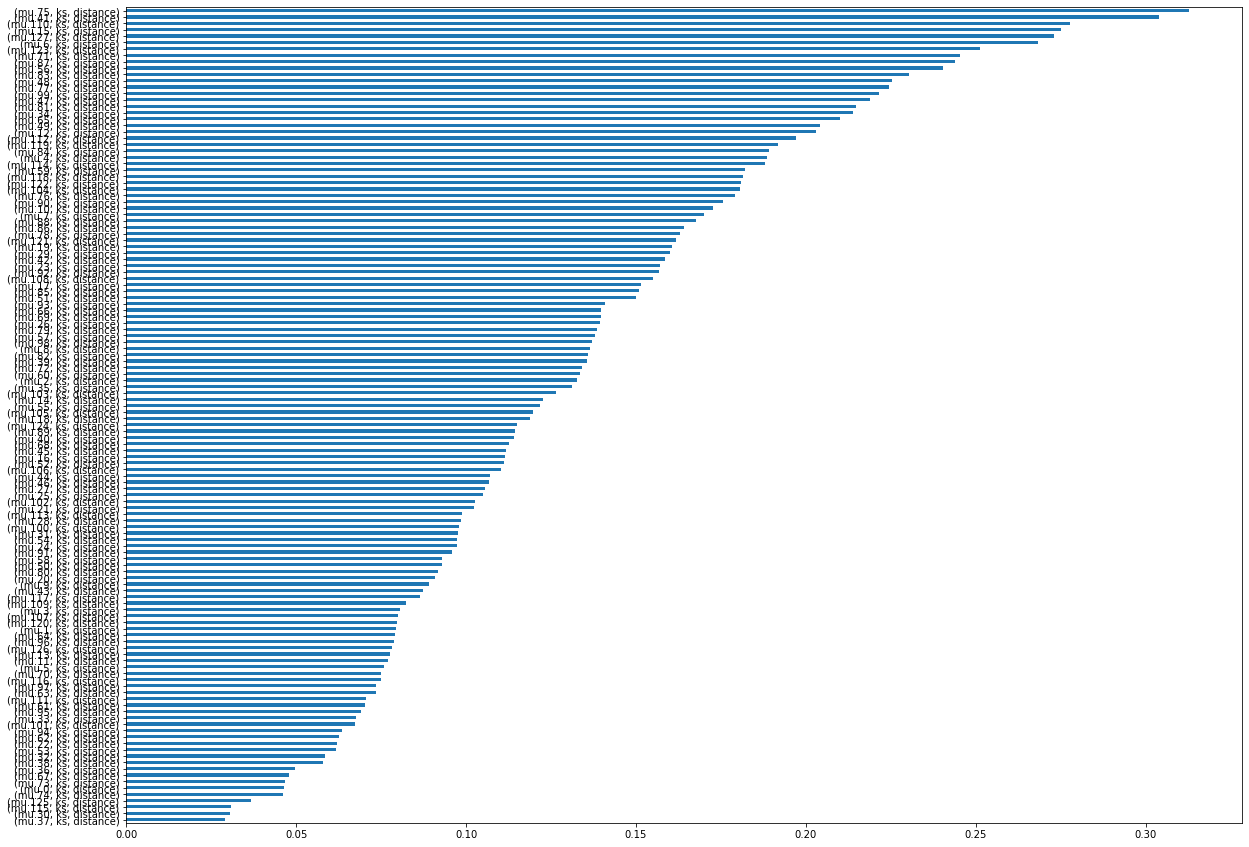

In [297]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
m.mean(axis=1).sort_values().plot(kind='barh', ax=ax)

In [291]:
display(m_top.corr())
display(m.corr())

,info_gain,correlation
info_gain,1.000000,0.079119
correlation,0.079119,1.000000


,info_gain,correlation
info_gain,1.000000,0.543112
correlation,0.543112,1.000000


In [361]:
other_df = merge_frames(input_df, score_df, vae_df)
other_df.head()


Modality_DICOM                                   PatientSex_DICOM  \
                     chi2                                               chi2   
            critical_diff critical_value distance  dof pval    critical_diff   
2007-05-03            0.0            0.0      0.0  0.0  1.0        -2.672029   
2007-05-04            0.0            0.0      0.0  0.0  1.0        -2.672029   
2007-05-05            0.0            0.0      0.0  0.0  1.0        -2.672029   
2007-05-06            0.0            0.0      0.0  0.0  1.0        -2.672029   
2007-05-07            0.0            0.0      0.0  0.0  1.0        -2.672029   

                                                    ...     mu.97            \
                                                    ...        ks             
           critical_value  distance  dof      pval  ...  distance      pval   
2007-05-03        4.60517  1.933141  2.0  0.380385  ...  0.454575  0.665192   
2007-05-04        4.60517  1.933141  2.0  0.380385  ...  0.454575  0.665192   
2007-05-05        4.60517  1.933141  2.0  0.380385  ...  0.454575  0.665192   
2007-05-06        4.60517  1.933141  2.0  0.380385  ...  0.454575  0.665192   
2007-05-07        4.60517  1.933141  2.0  0.380385  ...  0.454575  0.665192   

                   mu.98                                            mu.99  \
                      ks                                               ks   
           critical_diff critical_value  distance      pval critical_diff   
2007-05-03     -0.371736       0.865448  0.493712  0.524836     -0.010925   
2007-05-04     -0.371736       0.865448  0.493712  0.524836     -0.010925   
2007-05-05     -0.371736       0.865448  0.493712  0.524836     -0.010925   
2007-05-06     -0.371736       0.865448  0.493712  0.524836     -0.010925   
2007-05-07     -0.371736       0.865448  0.493712  0.524836     -0.010925   

                                               
                                               
           critical_value  distance      pval  
2007-05-03       0.865448  0.854523  0.042327  
2007-05-04       0.865448  0.854523  0.042327  
2007-05-05       0.865448  0.854523  0.042327  
2007-05-06       0.865448  0.854523  0.042327  
2007-05-07       0.865448  0.854523  0.042327  

[5 rows x 586 columns]

In [363]:
all_corr_df

(Modality_DICOM, chi2, distance)             -0.221808
(PatientSex_DICOM, chi2, distance)            0.066617
(Projection, chi2, distance)                  0.122674
(RelativeXRayExposure_DICOM, ks, distance)   -0.339958
(WindowCenter_DICOM, ks, distance)           -0.306745
                                                ...   
(mu.95, ks, distance)                        -0.038600
(mu.96, ks, distance)                        -0.076391
(mu.97, ks, distance)                         0.065115
(mu.98, ks, distance)                        -0.159003
(mu.99, ks, distance)                        -0.321017
Name: correlation, Length: 145, dtype: float64

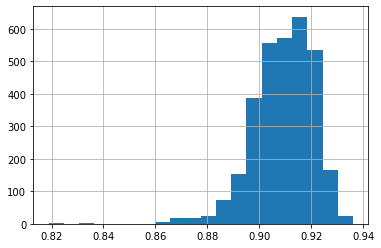

In [187]:
perf_df['score']['label']['auroc'].hist(bins=bins)


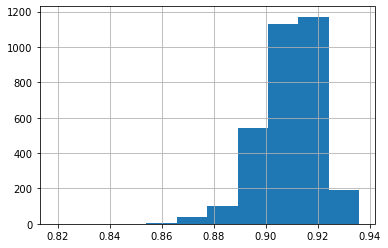

In [190]:
perf_df['score']['label']['auroc'].hist(bins=10)

In [182]:
q = [0.00, 0.05, 0.5, 0.9, 0.99]
out, bins = pd.qcut(perf_df['score']['label']['auroc'], q, retbins=True)

bins

array([0.8189773 , 0.89012983, 0.91013083, 0.92235078, 0.92917044])

Modality_DICOM                                         \
                     chi2                                          
            critical_diff critical_value      distance  dof pval   
2007-05-03       0.000000       0.000000      0.000000  0.0  1.0   
2007-05-04       0.000000       0.000000      0.000000  0.0  1.0   
2007-05-05       0.000000       0.000000      0.000000  0.0  1.0   
2007-05-06       0.000000       0.000000      0.000000  0.0  1.0   
2007-05-07       0.000000       0.000000      0.000000  0.0  1.0   
...                   ...            ...           ...  ...  ...   
2017-11-13   16887.583783       2.705543  16890.289326  1.0  0.0   
2017-11-14   17026.223308       2.705543  17028.928851  1.0  0.0   
2017-11-15   17073.011322       2.705543  17075.716866  1.0  0.0   
2017-11-16   17446.791812       2.705543  17449.497355  1.0  0.0   
2017-11-17   17512.361541       2.705543  17515.067085  1.0  0.0   

           PatientSex_DICOM                                          ...  \
                       chi2                                          ...   
              critical_diff critical_value  distance  dof      pval  ...   
2007-05-03        -2.672029        4.60517  1.933141  2.0  0.380385  ...   
2007-05-04        -2.672029        4.60517  1.933141  2.0  0.380385  ...   
2007-05-05        -2.672029        4.60517  1.933141  2.0  0.380385  ...   
2007-05-06        -2.672029        4.60517  1.933141  2.0  0.380385  ...   
2007-05-07        -2.672029        4.60517  1.933141  2.0  0.380385  ...   
...                     ...            ...       ...  ...       ...  ...   
2017-11-13         5.084967        4.60517  9.690137  2.0  0.007867  ...   
2017-11-14         4.884923        4.60517  9.490093  2.0  0.008695  ...   
2017-11-15         3.432346        4.60517  8.037517  2.0  0.017975  ...   
2017-11-16         4.182499        4.60517  8.787669  2.0  0.012353  ...   
2017-11-17         3.761306        4.60517  8.366476  2.0  0.015249  ...   

           activation.Pleural Effusion activation.Pneumonia                 \
                                    ks                   ks                  
                                  pval        critical_diff critical_value   
2007-05-03                3.966667e-01            -0.037869       0.865430   
2007-05-04                3.966667e-01            -0.037869       0.865430   
2007-05-05                3.966667e-01            -0.037869       0.865430   
2007-05-06                3.966667e-01            -0.037869       0.865430   
2007-05-07                3.966667e-01            -0.037869       0.865430   
...                                ...                  ...            ...   
2017-11-13                3.873818e-14             0.105611       0.039082   
2017-11-14                1.376534e-14             0.105399       0.038513   
2017-11-15                5.175621e-15             0.105709       0.037788   
2017-11-16                4.087149e-16             0.100247       0.038019   
2017-11-17                7.999480e-17             0.096697       0.038340   

                                                 count             mu  \
                                   Unnamed: 41_level_1             ks   
            distance          pval Unnamed: 41_level_2 critical_value   
2007-05-03  0.827561  5.947019e-02                 2.0       0.865448   
2007-05-04  0.827561  5.947019e-02                 2.0       0.865448   
2007-05-05  0.827561  5.947019e-02                 2.0       0.865448   
2007-05-06  0.827561  5.947019e-02                 2.0       0.865448   
2007-05-07  0.827561  5.947019e-02                 2.0       0.865448   
...              ...           ...                 ...            ...   
2017-11-13  0.144693  2.186802e-18              1026.0       0.039471   
2017-11-14  0.143912  1.022474e-18              1058.0       0.038908   
2017-11-15  0.143497  2.597229e-19              1101.0       0.038190   
2017-11-16  0.138266  9.

In [163]:
perf_df

,score
,label
,auroc
2009-01-02,0.904769
2009-01-03,0.907639
2009-01-04,0.907042
2009-01-05,0.904743
2009-01-06,0.904257
...,...
2017-11-13,0.889057
2017-11-14,0.890720


In [164]:
perf_df['score']['label']

,auroc
2009-01-02,0.904769
2009-01-03,0.907639
2009-01-04,0.907042
2009-01-05,0.904743
2009-01-06,0.904257
...,...
2017-11-13,0.889057
2017-11-14,0.890720
2017-11-15,0.889868
2017-11-16,0.892832


In [165]:
flatten_index(other_df)

,Modality_DICOM.chi2.critical_diff,Modality_DICOM.chi2.critical_value,Modality_DICOM.chi2.distance,Modality_DICOM.chi2.dof,Modality_DICOM.chi2.pval,PatientSex_DICOM.chi2.critical_diff,PatientSex_DICOM.chi2.critical_value,PatientSex_DICOM.chi2.distance,PatientSex_DICOM.chi2.dof,PatientSex_DICOM.chi2.pval,...,activation.Pleural Effusion.ks.pval,activation.Pneumonia.ks.critical_diff,activation.Pneumonia.ks.critical_value,activation.Pneumonia.ks.distance,activation.Pneumonia.ks.pval,count.Unnamed: 41_level_1.Unnamed: 41_level_2,mu.ks.critical_value,mu.ks.distance,mu.ks.critical_diff,mu.ks.pval
2007-05-03,0.000000,0.000000,0.000000,0.0,1.0,-2.672029,4.60517,1.933141,2.0,0.380385,...,3.966667e-01,-0.037869,0.865430,0.827561,5.947019e-02,2.0,0.865448,0.532256,-0.333192,0.507699
2007-05-04,0.000000,0.000000,0.000000,0.0,1.0,-2.672029,4.60517,1.933141,2.0,0.380385,...,3.966667e-01,-0.037869,0.865430,0.827561,5.947019e-02,2.0,0.865448,0.532256,-0.333192,0.507699
2007-05-05,0.000000,0.000000,0.000000,0.0,1.0,-2.672029,4.60517,1.933141,2.0,0.380385,...,3.966667e-01,-0.037869,0.865430,0.827561,5.947019e-02,2.0,0.865448,0.532256,-0.333192,0.507699
2007-05-06,0.000000,0.000000,0.000000,0.0,1.0,-2.672029,4.60517,1.933141,2.0,0.380385,...,3.966667e-01,-0.037869,0.865430,0.827561,5.947019e-02,2.0,0.865448,0.532256,-0.333192,0.507699
2007-05-07,0.000000,0.000000,0.000000,0.0,1.0,-2.672029,4.60517,1.933141,2.0,0.380385,...,3.966667e-01,-0.037869,0.865430,0.827561,5.947019e-02,2.0,0.865448,0.532256,-0.333192,0.507699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-13,16887.583783,2.705543,16890.289326,1.0,0.0,5.084967,4.60517,9.690137,2.0,0.007867,...,3.873818e-14,0.105611,0.039082,0.144693,2.186802e-18,1026.0,0.039471,0.087643,0.048172,0.068174
2017-11-14,17026.223308,2.705543,17028.928851,1.0,0.0,4.884923,4.60517,9.490093,2.0,0.008695,...,1.376534e-14,0.105399,0.038513,0.143912,1.022474e-18,1058.0,0.038908,0.087407,0.048500,0.061855
2017-11-15,17073.011322,2.705543,17075.716866,1.0,0.0,3.432346,4.60517,8.037517,2.0,0.017975,...,5.175621e-15,0.105709,0.037788,0.143497,2.597229e-19,1101.0,0.038190,0.086928,0.048737,0.057012
2017-11-16,17446.791812,2.705543,17449.497355,1.0,0.0,4.182499,4.60517,8.787669,2.0,0.012353,...,4.087149e-16,0.100247,0.038019,0.138266,9.719320e-18,1087.0,0.038419,0.086052,0.047633,0.057334


In [167]:
correlate_performance(perf_df['score']['label'], (other_df), include='distance')


[('Modality_DICOM', 'chi2', 'distance'), ('PatientSex_DICOM', 'chi2', 'distance'), ('Projection', 'chi2', 'distance'), ('RelativeXRayExposure_DICOM', 'ks', 'distance'), ('WindowCenter_DICOM', 'ks', 'distance'), ('WindowWidth_DICOM', 'ks', 'distance'), ('age', 'ks', 'distance'), ('activation.Atelectasis', 'ks', 'distance'), ('activation.Cardiomegaly', 'ks', 'distance'), ('activation.Consolidation', 'ks', 'distance'), ('activation.Edema', 'ks', 'distance'), ('activation.Lesion', 'ks', 'distance'), ('activation.No Finding', 'ks', 'distance'), ('activation.Opacity', 'ks', 'distance'), ('activation.Pleural Abnormalities', 'ks', 'distance'), ('activation.Pleural Effusion', 'ks', 'distance'), ('activation.Pneumonia', 'ks', 'distance'), ('mu', 'ks', 'distance')] auroc
3170 3170


(Modality_DICOM, chi2, distance)                   -0.221808
(PatientSex_DICOM, chi2, distance)                  0.066617
(Projection, chi2, distance)                        0.122674
(RelativeXRayExposure_DICOM, ks, distance)         -0.339958
(WindowCenter_DICOM, ks, distance)                 -0.306745
(WindowWidth_DICOM, ks, distance)                  -0.379410
(age, ks, distance)                                -0.049986
(activation.Atelectasis, ks, distance)             -0.339617
(activation.Cardiomegaly, ks, distance)            -0.310372
(activation.Consolidation, ks, distance)           -0.474447
(activation.Edema, ks, distance)                   -0.404087
(activation.Lesion, ks, distance)                  -0.422628
(activation.No Finding, ks, distance)              -0.286608
(activation.Opacity, ks, distance)                 -0.411941
(activation.Pleural Abnormalities, ks, distance)   -0.394158
(activation.Pleural Effusion, ks, distance)        -0.349318
(activation.Pneumonia, k

In [128]:
flatten_index(df)

,Modality_DICOM.chi2.critical_diff,Modality_DICOM.chi2.critical_value,Modality_DICOM.chi2.distance,Modality_DICOM.chi2.dof,Modality_DICOM.chi2.pval,PatientSex_DICOM.chi2.critical_diff,PatientSex_DICOM.chi2.critical_value,PatientSex_DICOM.chi2.distance,PatientSex_DICOM.chi2.dof,PatientSex_DICOM.chi2.pval,...,activation.Pleural Abnormalities.ks.pval,activation.Pleural Effusion.ks.critical_diff,activation.Pleural Effusion.ks.critical_value,activation.Pleural Effusion.ks.distance,activation.Pleural Effusion.ks.pval,activation.Pneumonia.ks.critical_diff,activation.Pneumonia.ks.critical_value,activation.Pneumonia.ks.distance,activation.Pneumonia.ks.pval,count.Unnamed: 41_level_1.Unnamed: 41_level_2
2009-01-02,0.000000,0.000000,0.000000,0.0,1.0,-4.556489,4.60517,0.048681,2.0,0.975953,...,1.769945e-07,0.184318,0.143476,0.327794,1.735252e-07,0.069415,0.143476,0.212891,2.208792e-03,73.0
2009-01-03,0.000000,0.000000,0.000000,0.0,1.0,-4.592392,4.60517,0.012778,2.0,0.993631,...,1.602256e-07,0.167200,0.138817,0.306017,5.564327e-07,0.075188,0.138817,0.214005,1.294650e-03,78.0
2009-01-04,0.000000,0.000000,0.000000,0.0,1.0,-4.359212,4.60517,0.245958,2.0,0.884282,...,1.112690e-09,0.208458,0.132227,0.340685,2.061707e-09,0.102052,0.132227,0.234279,1.234701e-04,86.0
2009-01-05,0.000000,0.000000,0.000000,0.0,1.0,-4.535856,4.60517,0.069314,2.0,0.965937,...,1.946839e-05,0.081334,0.083486,0.164819,1.426032e-05,0.065785,0.083486,0.149271,1.202258e-04,217.0
2009-01-06,0.000000,0.000000,0.000000,0.0,1.0,-4.478921,4.60517,0.126250,2.0,0.938826,...,7.370310e-07,0.094546,0.080257,0.174803,1.069781e-06,0.088055,0.080257,0.168312,3.073061e-06,235.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-13,16887.583783,2.705543,16890.289326,1.0,0.0,5.084967,4.60517,9.690137,2.0,0.007867,...,4.644012e-12,0.087395,0.039082,0.126477,3.873818e-14,0.105611,0.039082,0.144693,2.186802e-18,1026.0
2017-11-14,17026.223308,2.705543,17028.928851,1.0,0.0,4.884923,4.60517,9.490093,2.0,0.008695,...,1.333563e-12,0.088165,0.038513,0.126678,1.376534e-14,0.105399,0.038513,0.143912,1.022474e-18,1058.0
2017-11-15,17073.011322,2.705543,17075.716866,1.0,0.0,3.432346,4.60517,8.037517,2.0,0.017975,...,5.964311e-13,0.088370,0.037788,0.126158,5.175621e-15,0.105709,0.037788,0.143497,2.597229e-19,1101.0
2017-11-16,17446.791812,2.705543,17449.497355,1.0,0.0,4.182499,4.60517,8.787669,2.0,0.012353,...,5.567089e-14,0.093622,0.038019,0.131641,4.087149e-16,0.100247,0.038019,0.138266,9.719320e-18,1087.0


In [42]:
output2 = df.swaplevel(0, -1, axis=1)
output2.columns = ['.'.join(c) for c in output2.columns.to_flat_index()]
output2.head()


,critical_diff.chi2.Modality_DICOM,critical_value.chi2.Modality_DICOM,distance.chi2.Modality_DICOM,dof.chi2.Modality_DICOM,pval.chi2.Modality_DICOM,critical_diff.chi2.PatientSex_DICOM,critical_value.chi2.PatientSex_DICOM,distance.chi2.PatientSex_DICOM,dof.chi2.PatientSex_DICOM,pval.chi2.PatientSex_DICOM,...,pval.ks.activation.Pleural Abnormalities,critical_diff.ks.activation.Pleural Effusion,critical_value.ks.activation.Pleural Effusion,distance.ks.activation.Pleural Effusion,pval.ks.activation.Pleural Effusion,critical_diff.ks.activation.Pneumonia,critical_value.ks.activation.Pneumonia,distance.ks.activation.Pneumonia,pval.ks.activation.Pneumonia,Unnamed: 41_level_2.Unnamed: 41_level_1.count
2009-01-02,0.0,0.0,0.0,0.0,1.0,-4.556489,4.60517,0.048681,2.0,0.975953,...,1.769945e-07,0.184318,0.143476,0.327794,1.735252e-07,0.069415,0.143476,0.212891,0.002209,73.0
2009-01-03,0.0,0.0,0.0,0.0,1.0,-4.592392,4.60517,0.012778,2.0,0.993631,...,1.602256e-07,0.167200,0.138817,0.306017,5.564327e-07,0.075188,0.138817,0.214005,0.001295,78.0
2009-01-04,0.0,0.0,0.0,0.0,1.0,-4.359212,4.60517,0.245958,2.0,0.884282,...,1.112690e-09,0.208458,0.132227,0.340685,2.061707e-09,0.102052,0.132227,0.234279,0.000123,86.0
2009-01-05,0.0,0.0,0.0,0.0,1.0,-4.535856,4.60517,0.069314,2.0,0.965937,...,1.946839e-05,0.081334,0.083486,0.164819,1.426032e-05,0.065785,0.083486,0.149271,0.000120,217.0
2009-01-06,0.0,0.0,0.0,0.0,1.0,-4.478921,4.60517,0.126250,2.0,0.938826,...,7.370310e-07,0.094546,0.080257,0.174803,1.069781e-06,0.088055,0.080257,0.168312,0.000003,235.0


In [118]:
df.xs('chi2', axis=1)

KeyError: 'chi2'

In [115]:
df[pd.IndexSlice["chi2"]]

KeyError: 'chi2'

auroc.label.score
['distance.chi2.Modality_DICOM', 'pval.chi2.Modality_DICOM', 'distance.chi2.PatientSex_DICOM', 'pval.chi2.PatientSex_DICOM', 'distance.chi2.Projection', 'pval.chi2.Projection', 'distance.ks.RelativeXRayExposure_DICOM', 'pval.ks.RelativeXRayExposure_DICOM', 'distance.ks.WindowCenter_DICOM', 'pval.ks.WindowCenter_DICOM', 'distance.ks.WindowWidth_DICOM', 'pval.ks.WindowWidth_DICOM', 'distance.ks.age', 'pval.ks.age', 'distance.ks.mu', 'pval.ks.mu', 'distance.ks.activation.Atelectasis', 'pval.ks.activation.Atelectasis', 'distance.ks.activation.Cardiomegaly', 'pval.ks.activation.Cardiomegaly', 'distance.ks.activation.Consolidation', 'pval.ks.activation.Consolidation', 'distance.ks.activation.Edema', 'pval.ks.activation.Edema', 'distance.ks.activation.Lesion', 'pval.ks.activation.Lesion', 'distance.ks.activation.No Finding', 'pval.ks.activation.No Finding', 'distance.ks.activation.Opacity', 'pval.ks.activation.Opacity', 'distance.ks.activation.Pleural Abnormalities', 'pval.k

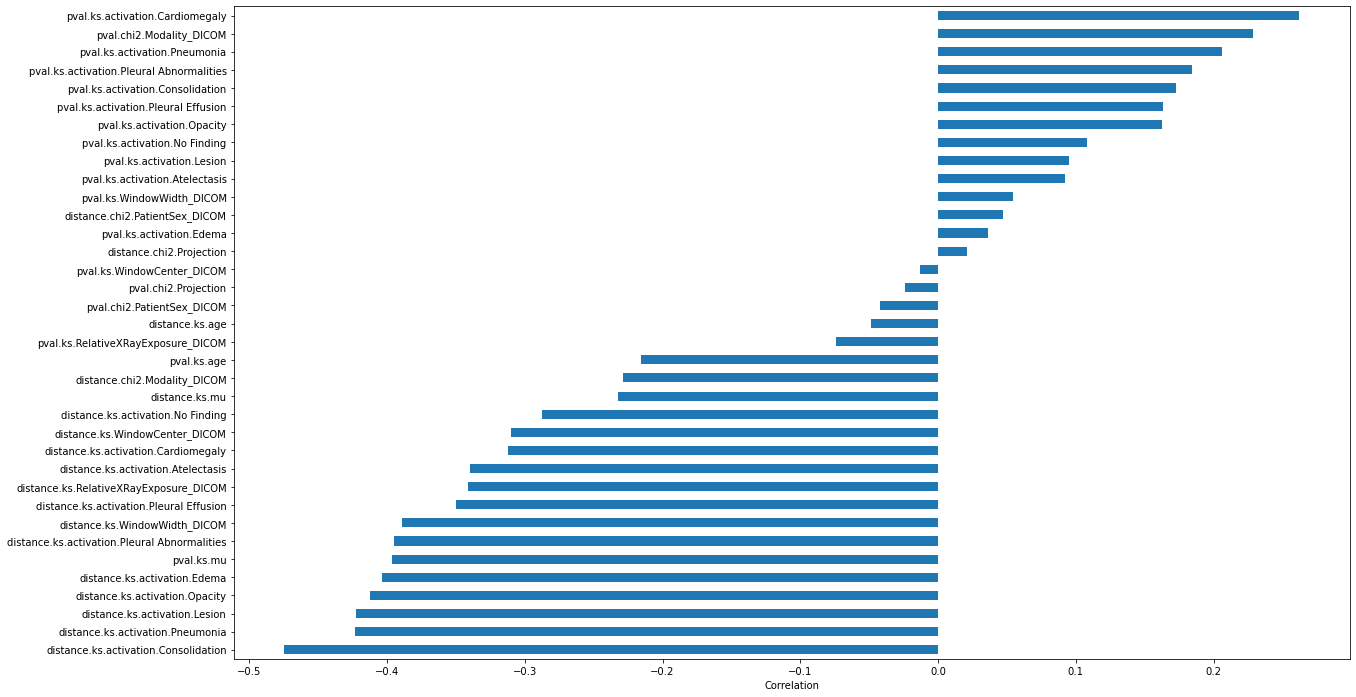

In [72]:
target_col = [c for c in list(output2) if 'auroc' in c][0]
print(target_col)

keep = ['pval', "distance", 'stat']
corr_cols = [c for c in list(output2) if target_col not in c and any(k in c for k in keep)]
print(corr_cols)
corrs = output2[corr_cols].apply(pd.np.tanh).corrwith(
    output2[target_col]).sort_values()
ax = corrs.plot(kind='barh', figsize=(20, 12))

ax.set_xlabel('Correlation')
plt.show()


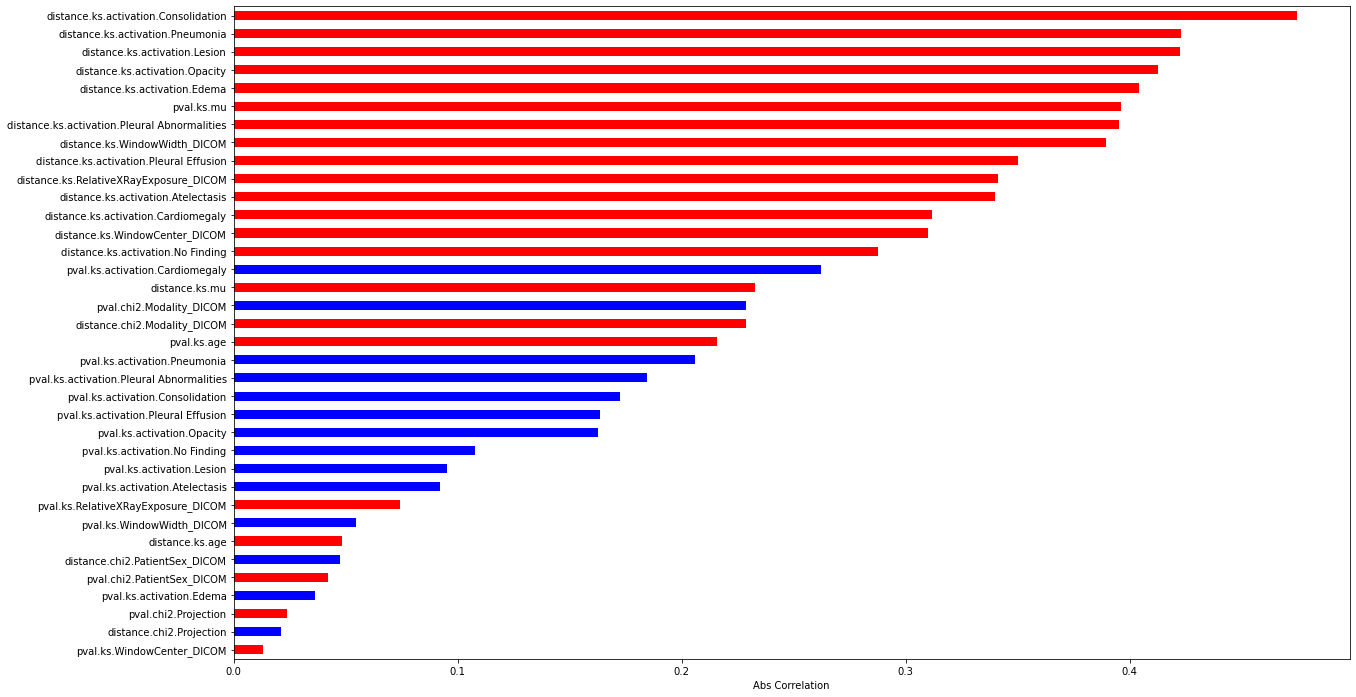

In [101]:
n = "abs-correlation"
corrs.name =n

abs_corrs = corrs.abs().to_frame()
abs_corrs['color'] = ['red' if cc < 0 else 'blue' for cc in corrs]

abs_corrs = abs_corrs.sort_values(by=n)
ax = abs_corrs[n].plot(kind='barh', figsize=(20, 12), color=abs_corrs['color'])

ax.set_xlabel('Abs Correlation')
plt.show()


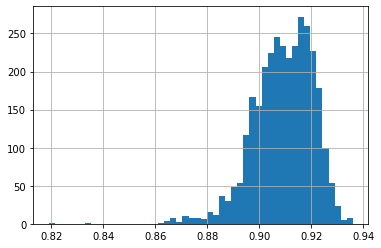

In [102]:
Y = output2[target_col]
Y.hist(bins=50)

In [103]:
np.linspace(0.8, 1, 20)


array([0.8       , 0.81052632, 0.82105263, 0.83157895, 0.84210526,
       0.85263158, 0.86315789, 0.87368421, 0.88421053, 0.89473684,
       0.90526316, 0.91578947, 0.92631579, 0.93684211, 0.94736842,
       0.95789474, 0.96842105, 0.97894737, 0.98947368, 1.        ])

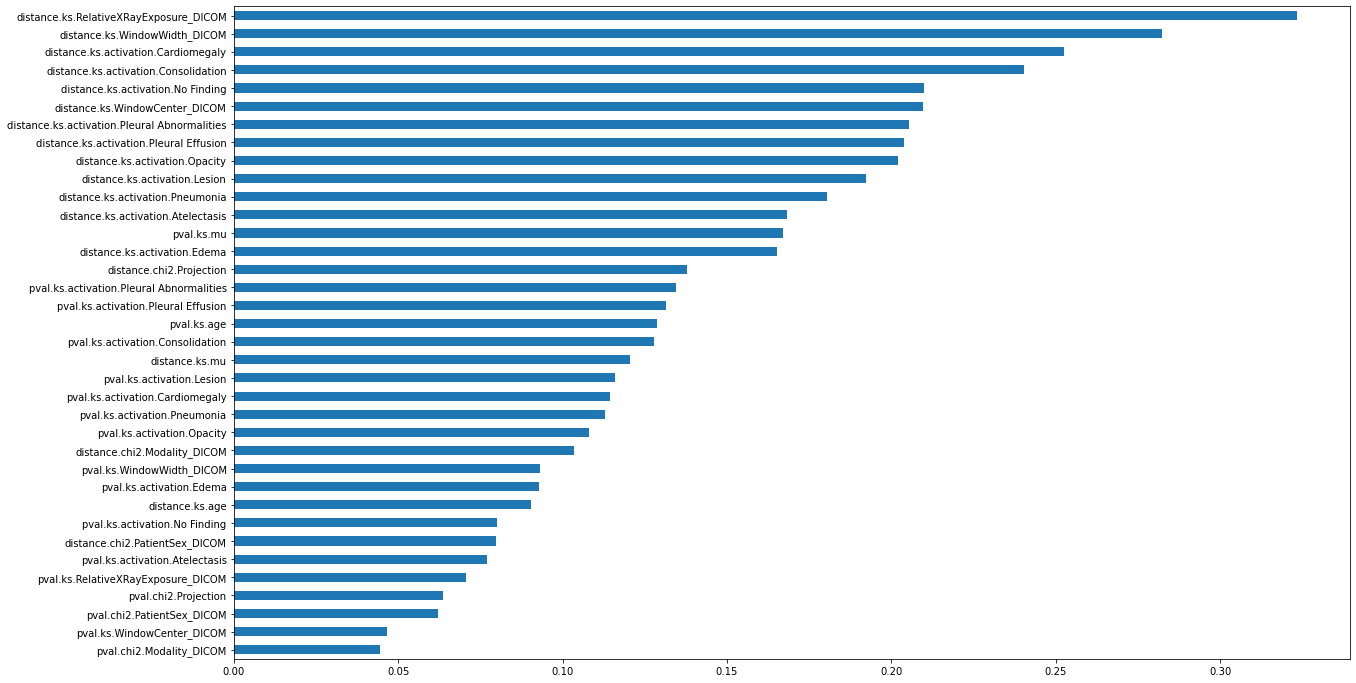

In [104]:
from sklearn.feature_selection import mutual_info_classif

X = output2[corr_cols].dropna(axis=1)
Y = output2[target_col]
Yb = pd.np.digitize(Y, bins=np.linspace(0.8, 1, 20))
info = mutual_info_classif(X, Yb)

info_gain = dict(zip(list(X), info))
fig, ax = plt.subplots()
info_gain = pd.Series(info_gain, name="info_gain").sort_values()
info_gain.plot(kind='barh',  figsize=(20, 12))


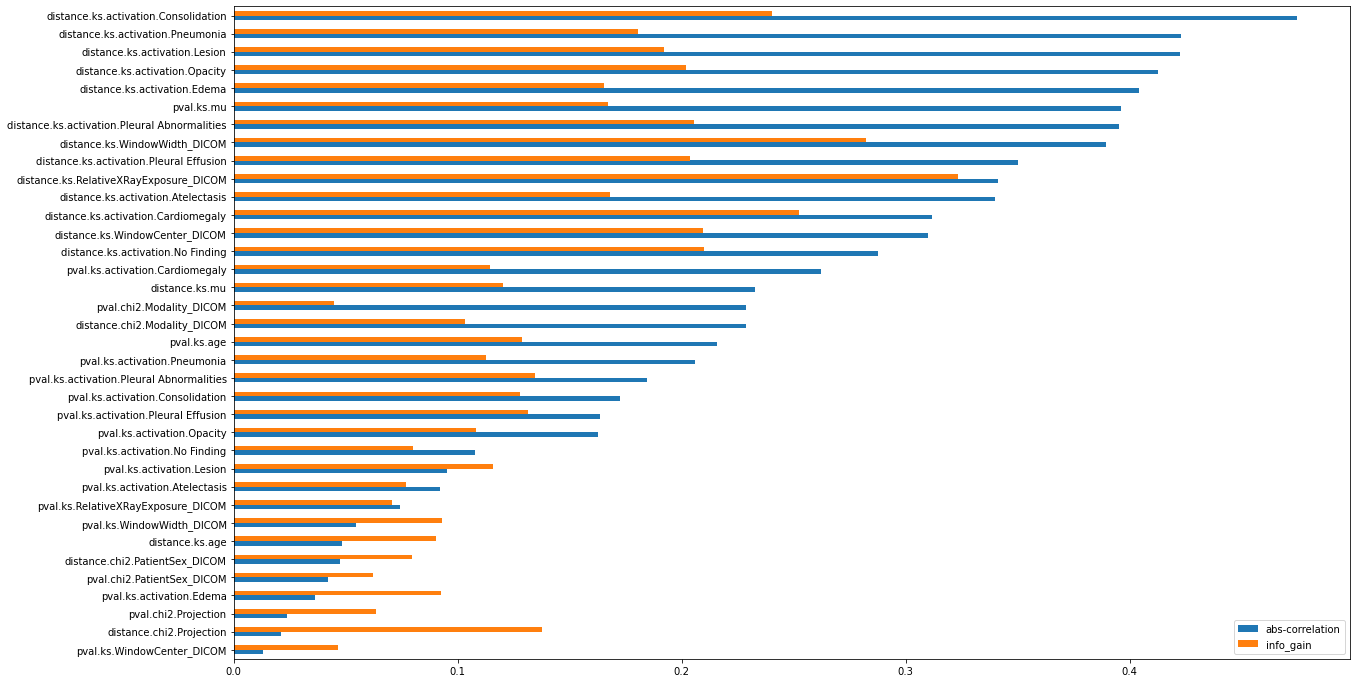

In [106]:
m = abs_corrs.join(info_gain)
m.drop("color", axis=1).plot.barh(figsize=(20, 12))


In [107]:
m.drop("color", axis=1).corr()


,abs-correlation,info_gain
abs-correlation,1.000000,0.783783
info_gain,0.783783,1.000000
